# Title

First thing, let's import some libraries:


In [1]:
from MCL.World import World
from MCL.Robot import Robot
from MCL.MCL import MCL
import numpy as np
import matplotlib.pyplot as plt

*Note: I treated the classes we got as open-source so I feel free to make some changes
in them.*

## Plotting Robots

In order to get more familiar with the `Robot` and `World` classes we were asked to
plot some robots in a world:


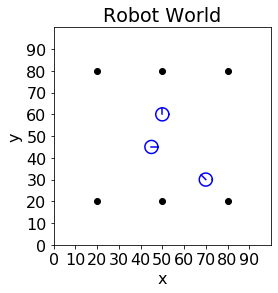

In [2]:
# Create the world & robots
poses = [(45, 45, 0), (50, 60, np.pi / 2), (70, 30, 3 * np.pi / 4)]
robots = [Robot(init_pose=p) for p in poses]
world = World()

# Plot world & robots
world.plot(show=False)
list(map(lambda x: x.plot(show=False), robots))
plt.show()

## Adding `move()` method

In order to implement a `move` method as required I used the given model
motion equations with some noise. First I injected a little noise into the motion commands
$u_1$ and $u_2$ as follows:

$$u_1 = u_1 + \delta_1, \quad \delta_1 \sim \mathcal{N}(0, \sigma_1)$$
$$u_2 = u_2 + \delta_2, \quad \delta_2 \sim \mathcal{N}(0, \sigma_2)$$

Then I implemented the motion model equations as part of the `move()` method.
After computing the new $(x,y,\theta)$ position I used the giving `set()` method
to set the current robot's position to the computed new position.

## Adding `sense()` method

Next we implemented a `sense` method which get list of landmarks, where
each landmark is a tuple of x and y position and return list of measurements.
Each measurement $i$ from the measurements list is also a tuple of
distance and bearing from the $i$ landmark. The follows equation
been used to compute the range and bearing:

$$range_i = \sqrt{(m_{i, x} - x)^2 + (m_{i, y} - y)^2} + \delta_{range}$$ <br>
$$bearing_i = \operatorname{atan2}(m_{i, y} - y, m_{i, x} - x) - \theta + \delta_{bearing}$$

where,

$$\delta_{range} \sim \mathcal{N}(0, \sigma_{range}), \quad \delta_{bearing} \sim \mathcal{N}(0, \sigma_{bearing})$$

and $i$ denote the $i$ landmark.

## Adding `measurement_probability` method

The `measurement_probability()` method gets the follow arguments:

1. `measurement` - the measurement we got when we used the `sense()` method,
in the form of $(r, \phi)$. Usually known as $z_t$.

1. `landmark` - the position of the landmark we measured $(r, \phi)$ to it,
in the form of $(m_x,m_y)$. Usually known as $m$

The method compute the follows expression:

$$p(z_t | x_t, m) = prob(r - \hat{r}, \sigma_r) * prob(\phi - \hat{\phi}, \sigma_{\phi})$$

where:

$$\hat{r} = \sqrt{(m_x - x)^2 - (m_y - y)^2}, \quad \hat{\phi} = atan2(m_y - y, m_x - x) - \theta$$

When I tried to use `norm` function from `scipy.stat` I noticed the long run time of
creating a norm distribution and getting a probability for a given $x$ value. Hence, I implemented
my own `norm_pdf(x, mean, std)` function which get `x` as a value and $(\mu, \sigma)$ as `mean` and `std`. The function
return the probability for the given $x$.

## Robot Performance - Without Noise

In order to plot the given commands I added an attribute to the `Robot` class. The new attribute is a list
named `path` and contains all the $(x, y)$ points the robot was located at them. In the
`__init__` method the initial pose append to `path` and in each call of the `move` method
the new position appended to the `path` list.

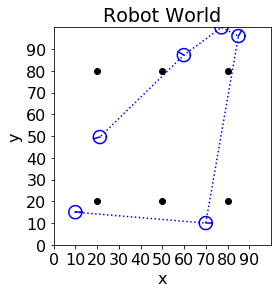

In [8]:
# Init world & robot
world = World()
robot = Robot(init_pose=(10, 15, 0))
moves = [(0, 60), (np.pi / 3, 30), (np.pi / 4, 30), (np.pi / 4, 20), (np.pi / 4, 40)]

# Init plot
world.plot()
robot.plot()

# Make the moves and plot them
for u_1, u_2 in moves:
    robot.move(u_1, u_2)
    robot.plot()

# Add the dotted line and plot
plt.plot(*(zip(*robot.path)), 'b:')
plt.show()


We can see the robot move perfectly without any noise in the motion commands. So now we
need to examine how it look like where we add some noise.

## Robot Performance - With Noise

We add another robot to the world, but now with some noise. The new robot's initial pose is also $(10,15,0)$
but the second robot will have noisy motor commands. The noise defined to be $\sigma_1=0.1$
and $\sigma_2 = 6$. Now we plot both robot moves on the same plot:


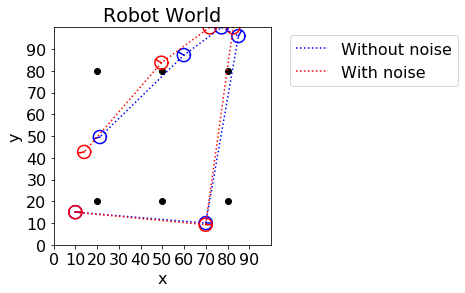

In [4]:
# Init both robots
robot_1 = Robot(init_pose=(10, 15, 0))
robot_2 = Robot(init_pose=(10, 15, 0), noise_std={'forward': 6, 'turn': 0.1, 'range': 5, 'bearing': 0.3})

# Init plot
world.plot()
robot_1.plot()
robot_2.plot(mycolor='r')

# Move both robots and plot the moves
for u_1, u_2 in moves:
    robot_1.move(u_1, u_2)
    robot_2.move(u_1, u_2)
    robot_1.plot()
    robot_2.plot(mycolor='r')

# Add the robot path
plt.plot(*(zip(*robot_1.path)), 'b:', label='Without noise')
plt.plot(*(zip(*robot_2.path)), 'r:', label='With noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()